# 

In [19]:
import torch
import ray
import sys, os
from typing import Optional, Union, List
import multiprocessing
import numpy as np
import faiss
import mdtraj as md
import matplotlib.pyplot as plt
from seaborn import kdeplot

from writhe_tools.md_tools import traj_slice, Rg, ResidueDistances, calc_sa, tangent_corr, bending_energy
from writhe_tools.md_tools import curvature_menger as curvature
from writhe_tools.utils import lsdir, load_dict, combinations, save_dict, load_dict, group_by, reindex_list, Timer
from writhe_tools.writhe import Writhe, window_average, to_laplacian
from writhe_tools.plots import (subplots_proj2d, subplots_fes2d, lineplot1D,
                                box_plot, plot_distance_matrix, build_matrix_boxplot_grid,
                                build_grid_plot, annotated_matrix_plot)
from writhe_tools.tcca import tCCA
from writhe_tools.stats import pca, standardize, get_extrema, MaxEntropyReweight, mean




trajs_all = ["/data/writhe/actr/ACTR-a99SBdisp-Traj.dcd",
         "/data/top_complexity/calvados2_ensembles/ACTR/ACTR_converted.xtc",
         "/data/top_complexity/bAIes/traj_ACTR_bAIes.xtc",
         "/data/top_complexity/bioemu_ensembles/ACTR/samples_ready.xtc",
        ]
trajs = ["/data/writhe/actr/ACTR-a99SBdisp-Traj.dcd",
         "/data/top_complexity/calvados2_ensembles/ACTR/ACTR.dcd",
         "/data/top_complexity/bAIes/traj_ACTR_bAIes.xtc",
         "/data/top_complexity/bioemu_ensembles/ACTR/samples.xtc",
        ]
pdbs_all = ["/data/writhe/actr/actr.pdb",
            
        "/data/top_complexity/calvados2_ensembles/ACTR/ACTR_converted.pdb",
        "/data/top_complexity/bAIes/ACTR.pdb",
        "/data/top_complexity/bioemu_ensembles/ACTR/topology_ready.pdb",
        ]

pdbs = ["/data/writhe/actr/actr.pdb",
        "/data/top_complexity/calvados2_ensembles/ACTR/top.pdb",
        "/data/top_complexity/bAIes/ACTR.pdb",
        "/data/top_complexity/bioemu_ensembles/ACTR/topology.pdb",
        ]

helix_pdb = '/data/writhe/actr/actr.helix.pdb'
obs_path = '/data/top_complexity/observables/actr'
exp_cs_file = '/data/top_complexity/observables/actr/exp_cs.dat'

names = ['a99', 'calvados', 'bayes', 'bioemu']
labels = ['a99SB-disp', 'CALVADOS', 'bAIes', 'bioemu']
need_slice = [True, False, True, True]
colors = ['steelblue', 'orange','olivedrab', 'indianred']

# for traj, pdb, slice_, label in zip(trajs, pdbs, need_slice, labels):
#     t = md.load(traj, top=pdb)
#     print(t)



## Compute chemical shift predictions and save (don't re-run!)

In [ ]:
from tools import prepare_spart_path, parallel_chemical_shifts

prepare_sparta_path()
for index, name in enumerate(names):
    traj = md.load(trajs_all[index], top=pdbs_all[index])
    result = parallel_chemical_shifts(traj)
    save_dict(f'{obs_path}/{name}_cs.pkl', result)

## Load chemical shift predictions and align to available experimental data 

In [2]:
from tools import proc_exp_data, proc_forward_data, filter_observables
# get the raw experimental data
exp = proc_exp_data(exp_cs_file)
# load + filter the forward model predictions
forwards = [filter_observables(proc_forward_data(obs_path, i), exp)[0] for i in range(4)]
# filter the experimental data
exp  = filter_observables(forwards[0], exp)[-1]


/home/t/writhe/Writhe_Package_Lite/src/writhe_tools/utils/sorting.py:79: UserWarning: Not all strings contain a number, returning unsorted input list to avoid throwing an error. If you want to only consider strings that contain a digit, set indexed to True 
  warnings.warn("Not all strings contain a number, returning unsorted input list to avoid throwing an error. "


## Define some helper functions to partition the observables and data from different models

In [8]:
split_sample = np.cumsum(np.array([i[1][0].shape[-1] for i in forwards]))[:-1]
sample_split = lambda x : np.array_split(x, split_sample)
sample_labels = np.concatenate([np.ones(len(i[1][0].T)) * j for j, i in enumerate(forwards)])

split_value = np.cumsum(np.array([len(i) for i in forwards[1][1]]))[:-1]
value_split = lambda x : np.array_split(x, split_value)

reweight_indices = value_split(np.arange(sum(len(i) for i in exp[1])))

 ## Combined Reweighting

2025-12-15 01:31:13,489	INFO worker.py:2012 -- Started a local Ray instance.
/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/ray/_private/worker.py:2051: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


(pid=6539) [writhe_tools] ⏭️ Skipping 'graph_utils' (missing: torch_geometric)
(pid=6539) [writhe_tools] 👉 To enable this module, install: pip install writhe-tools[graph]


(pid=6539) /home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
(pid=6539)   from pandas.core.computation.check import NUMEXPR_INSTALLED
(pid=gcs_server) [2025-12-15 01:31:42,147 E 6293 6293] (gcs_server) gcs_server.cc:302: Failed to establish connection to the event+metrics exporter agent. Events and metrics will not be exported. Exporter agent status: RpcError: Running out of retries to initialize the metrics agent. rpc_code: 14
(pid=6538) /home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed). [repeated 4x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configu

0.28796331674728187 11.405850754007849


<Axes: title={'center': 'Combined Maximum Entropy Reweighting'}, ylabel='Population (%)'>

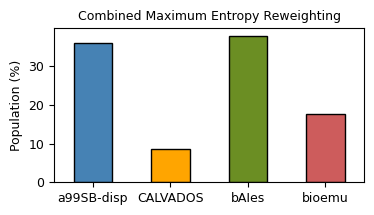

In [9]:
rw = MaxEntropyReweight(np.concatenate([np.concatenate(f[1]) for f in forwards], 1),
                        np.concatenate(exp[1]),
                        sigma_md = block_error(np.concatenate([np.concatenate(f[1]) for f in forwards], 1).T)[1]
                         )


rw.optimize_sigma_reg(reweight_indices,
                      global_steps=300,
                      standardize=False,
                      multi_proc=True,
                      #global_sigma_reg_u=20,
                      #global_steps=20,
                     )

result = rw.reweight(True, standardize=False)
print(result['rmse'], result['kish'])

populations = group_by(sample_labels, result['weights'], lambda x : 100 * np.sum(x))


box_plot(populations, labels=labels, color_list = colors,
         figsize=(4, 2), font_scale=1.5, width=.5,
        title='Combined Maximum Entropy Reweighting',
        ylabel = 'Population (%)')

## Individual Reweighting

In [ ]:
from tools import block_error, rmse
matrices = []
for kish in (80, 70, 60, 50, 40, 30, 20, 10, 7.5, 5, 3, 2, 1):
    rmses = []
    weights = []
    
    for i, f in enumerate(forwards):
        constraints = np.concatenate(f[1])
        rw = MaxEntropyReweight(constraints,
                                np.concatenate(exp[1]),
                                sigma_md = block_error(constraints.T)[1],
                                target_kish=kish
                             )
    
    
        rw.optimize_sigma_reg(reweight_indices,
                              global_steps=300,
                              standardize=False,
                              multi_proc=True,
                              #global_sigma_reg_u=20,
                              #global_steps=20,
                             )
        
        result = rw.reweight(True, standardize=False)
    
        rmses.append([rmse(i, j) for i, j in zip(value_split(result['weighted_mean']), value_split(rw.targets))])
    
        weights.append(result['weights'])
    
        print(result['kish'])
    matrices.append(np.stack(rmses, 1))
    


In [70]:
matrices = np.stack(matrices)

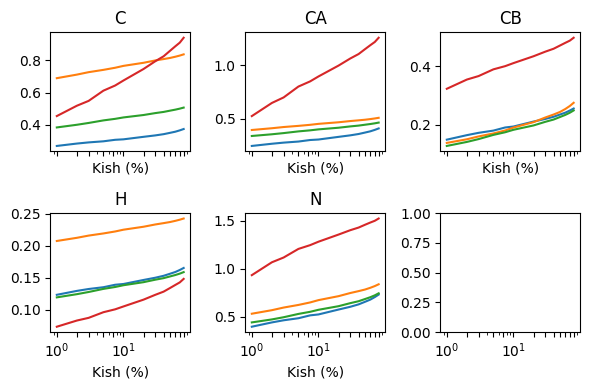

In [83]:
fig, axes = plt.subplots(2, 3, figsize=(6, 4), sharex=True)
for i, (ax, title) in enumerate(zip(axes.flat[:-1], exp[0])):
    for j in range(4):
        ax.plot((80, 70, 60, 50, 40, 30, 20, 10, 7.5, 5, 3, 2, 1),
                matrices[:, i, j],
                  )
        ax.set_title(title)
        ax.set_xscale("log")

        ax.set_xticks(np.array((80, 70, 60, 50, 40, 30, 20, 10, 7.5, 5, 3, 2, 1)).astype(int))
        ax.set_xlabel('Kish (%)')

fig.tight_layout()


<Axes: title={'center': 'Maximum Entropy Reweighting Results'}, ylabel='NMR Chemical Shift'>

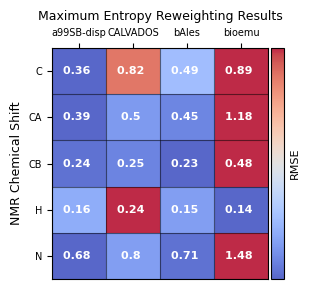

In [84]:
matrix = matrices[2]
color_matrix = (matrix -  matrix.min(1, keepdims=True)) / (matrix.max(1, keepdims=True) - matrix.min(1, keepdims=True))
annotated_matrix_plot(matrix,
                      color_matrix=color_matrix,
                      title = 'Maximum Entropy Reweighting Results',
                      xlabel='',
                      ylabel="NMR Chemical Shift",
                      cbar_label='RMSE',
                      xticks=labels,
                      yticks=exp[0],
                      font_scale=.2,
                      figsize=(3,3), 
                      xticks_top=True,
                      cmap='coolwarm',
                      hide_cbar_ticks=True,
                      grid=True,
                      alpha=.85
                 )
                  

 ## Compute geometric descriptors

In [97]:

singular_values = []
sa = []
distances = []
rg = []
all_writhes = []
bending_energies = []
persistence = []

for l in (1, 3, 5):
    writhes = []
    bends = []
    persistence_l = []
    
    for traj, pdb, slice_, label in zip(trajs, pdbs, need_slice, labels):
        
        t = md.load(traj, top=pdb, atom_indices = md.load(pdb).top.select('name CA') if slice_ else None).center_coordinates()
        # stride = round(t.n_frames / 10000)
        # print(stride)
        # t = t[::stride]
        # print(t.n_frames, t)
        
        writhe = Writhe(xyz=t.xyz).compute_writhe(l, cuda=True)['writhe_features']
        writhes.append(writhe)
        
        bends.append(bending_energy(t.xyz, l=l))

        persistence_l.append(tangent_corr(t.xyz, l=l))
        
        if l == 1:
            sa.append(np.pad(calc_sa(t, helix_pdb), (2, 3))[2:-3])
            print(sa[-1].shape)
            d = ResidueDistances(np.arange(t.xyz.shape[1]), t, periodic=False)
            distances.append(d.distances)
            rg.append(Rg(t.xyz))

            
        
    sigmas = [pca(i, scale = False)[1] for i in writhes]
    singular_values.append(sigmas)
    all_writhes.append(writhes)
    bending_energies.append(bends)
    persistence.append(persistence_l)
    print("finished")


lengths = np.fromiter(map(len, all_writhes[0]), int)

std_writhes = [np.array_split(standardize(np.concatenate(i, axis=0)),
                              np.cumsum(lengths)[:-1], axis=0) for i in all_writhes]

# std_writhes_weighted = [np.array_split(standardize(np.concatenate(i, axis=0), np.concatenate(weights)), 
#                                       np.cumsum(lengths)[:-1], axis=0)
#                         for i in all_writhes]


singular_values.append([pca(np.concatenate([i[j] for i in std_writhes], 1),
                            scale=False,
                            dask=False,
                            n_comp=11,
                            shift=True)[1]
                          for j in range(len(trajs))])


singular_values.append([pca(np.concatenate([i[j] for i in std_writhes], 1),
                            scale=False, 
                            dask=False,
                            shift=False,
                            n_comp=11,
                            weights=weight)[1]
                          for j, weight in enumerate(weights)])




(29977, 71)
(20010, 71)
(20000, 71)
(24264, 71)
finished
finished
finished


 ## Visualize fluctuations of writhe + alpha helix in unbiased ensembles

/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in scalar divide
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in scalar divide
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in scalar divide
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:
/home/t/miniconda3/envs/writhe/lib/python3.10/site-packages/pyblock/blocking.py:256: RuntimeWarning: invalid value encountered in scalar divide
  if B3 > 2*ndata*(var_std_err/std_err_first[i])**4:


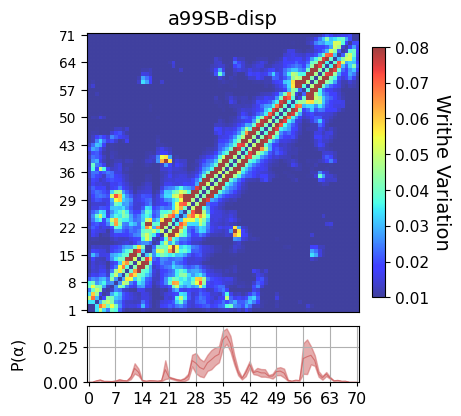

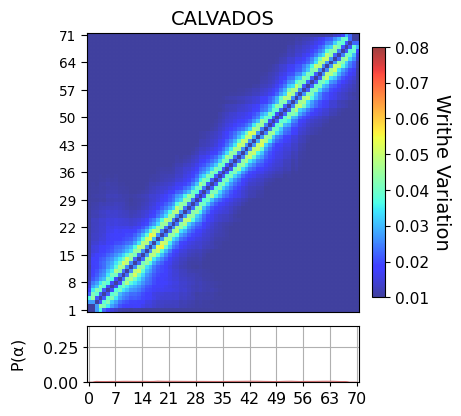

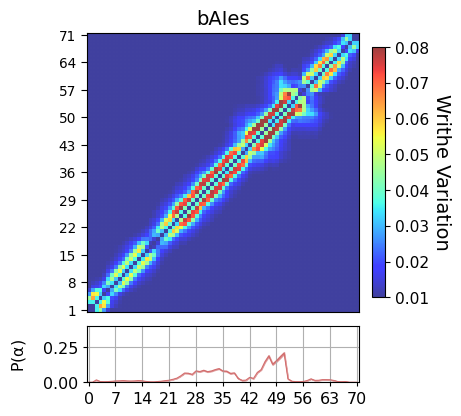

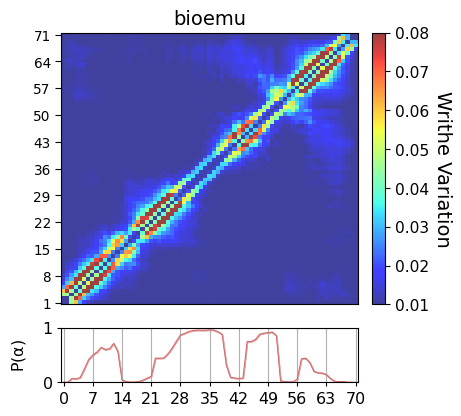

In [98]:


line_plot_args = dict(
                     label_stride=6,
                     color='indianred',
                     ymax = .4,
                     ylabel=r"P($\alpha$)",
                     ylabel_rotation = 90,
                     lw=.8,
                     grid=True,
                     alpha=.75,
                     fill_alpha=.5, 
                     fill_color='indianred',
                     font_scale=.2
                      )

matrix_plot_args = dict(grid=True,
                        grid_alpha=.1,
                        grid_linewidth = .05,
                        grid_color='lightgray',
                        label_stride=6,
                        vmax=0.08,
                        vmin=0.01,
                        cmap='jet',
                        alpha = .75,
                        xticks = np.arange(1, 72),
                        yticks = np.arange(1, 72),
                        cbar_label=r'Writhe Variation',
                        font_scale=1.5
                        #figsize=()
                        
                 )

for writhe, helix, label in zip(all_writhes[0], sa, labels):
    matrix_plot_args.update(dict(matrix=to_laplacian(writhe).std(0), title=label))
    mu, err = block_error(helix, True)
    line_plot_args.update(dict(y=mu, y1=err[0], y2=err[1]))
    if label == 'bioemu':
        line_plot_args['ymax'] = 1
    build_grid_plot(matrix_plot_args, line_plot_args)

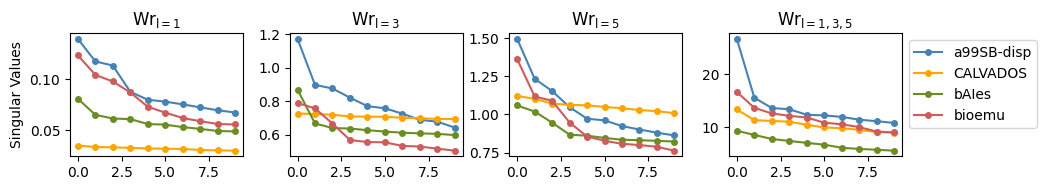

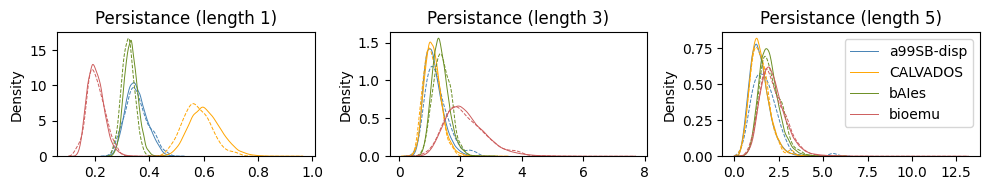

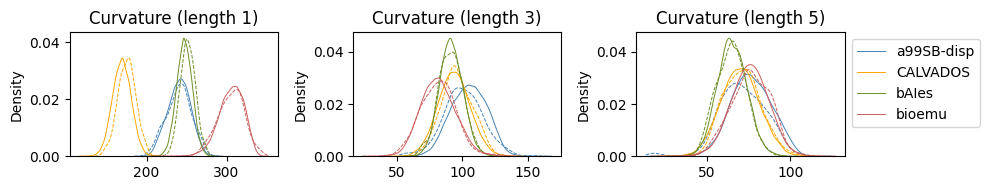

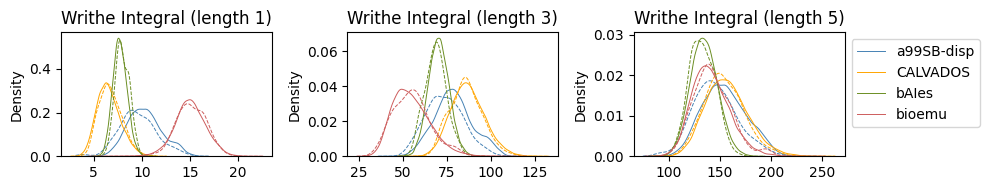

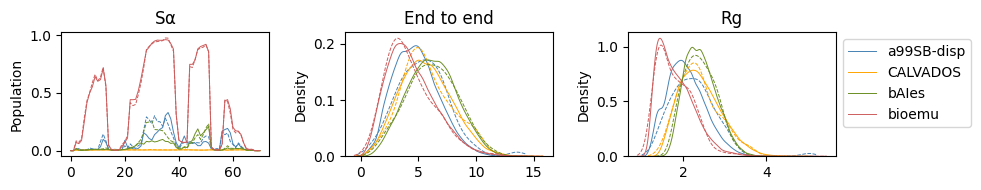

In [101]:
figsize = (10,2)

lw = .7
fig, axes = plt.subplots(1, 4, figsize=(10.66, 2), sharey=False, sharex=True)
for i, ax, length in zip(singular_values, axes.flat, "1,3,5".split(',') + 2 * ['1,3,5']):
    for j, label, color in zip(i, labels, colors):
        ax.plot(j[:10], label=label, marker='o', ms=4, color=color)
        ax.set_title(rf'$Wr_{{l={length}}}$')

axes[0].set_ylabel('Singular Values')
ax.legend(bbox_to_anchor=[1,1])
fig.tight_layout()            


fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False, sharex=False)
for i, ax, length in zip(persistence, axes.flat, "1,3,5".split(','),):
    for j, label, color, weight in zip(i, labels, colors, weights):
        kdeplot(j[0], label=f'{label}', ax=ax, color=color, lw=lw)
        kdeplot(x=j[0], ax=ax, weights=weight, ls='--', color=color, lw=lw)
    ax.set_title(f'Persistance (length {length})')

ax.legend(bbox_to_anchor=[1,1])
fig.tight_layout()


fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False, sharex=False)
for i, ax, length in zip(bending_energies, axes.flat, "1,3,5".split(',')):
    for j, label, color, weight in zip(i, labels, colors, weights):
        kdeplot(j, label=label, ax=ax, color=color, lw=lw)
        kdeplot(x=j,  ax=ax, weights=weight, color=color, ls='--', lw=lw)
    ax.set_title(f'Curvature (length {length})')

ax.legend(bbox_to_anchor=[1,1])
fig.tight_layout()            


fig, axes = plt.subplots(1, 3, figsize=figsize, sharey=False, sharex=False)
for i, ax, length in zip(all_writhes, axes.flat, "1,3,5".split(',')):
    for j, label, color, weight in zip(i, labels, colors, weights):
        kdeplot(abs(j).sum(-1), label=label, ax=ax, color=color, lw=lw)
        kdeplot(x=abs(j).sum(-1), ax=ax, weights=weight, color=color, ls='--', lw=lw)
    ax.set_title(rf'Writhe Integral (length {length})')

ax.legend(bbox_to_anchor=[1,1])
fig.tight_layout()


fig, axes = plt.subplots(1, 3, figsize=figsize)
for i, label, color, weight in zip(sa, labels, colors, weights):
    axes[0].plot(i.mean(0), label=label,  lw=lw, color=color)
    axes[0].plot(mean(i, weights=weight, ax=0), lw=lw, color=color, ls='--')
axes[0].set_title(r'S$\alpha$')
axes[0].set_ylabel('Population')

for i, label, color,  weight in zip([i[:, 69] for i in distances], labels, colors, weights):
    kdeplot(i, label=label, common_grid=True, ax=axes[1],  lw=lw, color=color)
    kdeplot(x=i, ax=axes[1], weights=weight, lw=lw, ls='--', color=color)
axes[1].set_title(r'End to end')

for i, label, color, weight in zip(rg, labels, colors, weights):
    kdeplot(i, label=label, common_grid=True, ax=axes[2], lw=lw, color=color)
    kdeplot(x=i, common_grid=True, ax=axes[2], weights=weight, lw=lw, color=color, ls='--')
axes[2].set_title(r'Rg')
axes[2].legend(bbox_to_anchor=[1,1])
fig.tight_layout()